# Portfolio: Olist e-commerce Customer Lifetime Value Prediction #

**Dataset:**
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses. The dataset can be found here https://www.kaggle.com/olistbr/brazilian-ecommerce.

**Goal:** 
To compute the customer lifetime value modeling using various formulas based on different business modeling needs.

**Results:** 
* Using the CLV by Cohort model, the majoriy of customers are distributed under the 100 CAD. 
* The estimated mean and median CLVs are 70.7 CAD and 37.5 CAD respectively.

**Future Work:**

**Recommendations for Clients:**


## Part 1 - DEFINE ##

**Problem Statement:** 
To compute the customer lifetime value modeling using various formulas based on different business modeling needs.

**Stakeholders:**
* Olist platform managers
* Olist product sellers
* Olist online customers.

In [1]:
# Import all libraries #
import sys
import re
import numpy as np
import pandas as pd
import csv
from datetime import datetime, date, timedelta
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import scipy.stats as sp
import sklearn.metrics as skm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

## Part 2 - DISCOVERY ##

In [2]:
#############################
# Part 2 - DISCOVER PHASE ###
#############################
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_as_category(df):
    '''convert datatype from object to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')


def convert_dt_as_date(df, var_name, date_format):
    '''convert the column as date format'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)


def convert_dt_as_date_object(df, col):
    '''convert datetime to object with parse date only'''
    df[col] = df[col].dt.date
    return df[col]


def join_data(df1, df2, join_type, key=None,
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def clean_data(raw_df):
    '''remove rows that contain duplicate columns'''
    clean_df = raw_df.drop_duplicates()
    # clean_df = raw_df.drop_duplicates(subset='customer_id')
    # clean_df = clean_df[clean_df.var_X > 0]
    # clean_df = clean_df[clean_df.var_Z <= 11000]
    return clean_df


def drop_data(df, var_list):
    '''drop variables from a dataframe'''
    df = df.drop(var_list, axis=1)
    return df


def EDA_missing_data(df):
    ''' compute missing value % on a df'''
    df_missing = pd.DataFrame(df.isnull().sum())
    df_missing.columns = ['count']
    df_missing = df_missing.sort_values(by='count', ascending=False)
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def EDA_summary_stat_num(df):
    ''' compute numerical summary statistics '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def EDA_summary_stat_cat(df):
    ''' compute numerical summary statistics '''
    df_stat_cat = pd.DataFrame(df.describe(include='category').T)
    # df_stat_cat = pd.DataFrame(df.describe(include='O').T)
    return df_stat_cat


def feature_replacement(df):
    ''' replace missing values based on specific data type of a column '''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            mode = df[col].mode().iloc[0]
            df[col] = df[col].fillna(mode)
        elif df[col].dtype.name == 'float64':
            mean = df[col].mean()
            df[col] = df[col].fillna(mean)
        elif df[col].dtype.name == 'datetime64[ns]':
            # pseudo_date = max(df[col])
            pseudo_date = pd.Timestamp.max
            df[col] = df[col].fillna(pseudo_date)
        else:
            df[col].dtype.name == 'int64'
            median = df[col].median()
            df[col] = df[col].fillna(median)


def get_dummies(df, var_name):
    '''Create a list of dummy vars'''
    dummies = pd.get_dummies(df[var_name], drop_first=True)
    return dummies    


def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''Performs RandomizedSearchCV to tune model parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search


def print_best_params(random_search, param_1=None, param_2=None, param_3=None):
    '''Print the best model parameter'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])


def model_train(model, X_train, y_train, n_proc, mean_mae, cv_std):
    '''Train a model and output mean MAE and CV Std. MAE'''
    #scoring = 'neg_mean_absolute_error', 'neg_mean_squared_error'
    # dont forget np.sqrt() for RMSE metric!
    neg_mae = cross_val_score(model, X_train, y_train, n_jobs=n_proc, cv=5,
                              scoring='neg_mean_absolute_error')
    mae = -1*neg_mae
    mean_mae[model] = np.mean(mae)
    cv_std[model] = np.std(mae)

def model_summary(model, mean_mae, cv_std):
    '''Print out the model performance summary'''
    print('\nModel:\n', model)
    print('Average MAE:\n', mean_mae[model])
    print('Std. Dev during CV:\n', cv_std[model])

    
def model_results(model, mean_mae, predictions, feature_importances):
    '''Saves the model name, mean_mae, predicted sales, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv',index=False)
        predictions.to_csv('pred_results_best.csv',index=False,index_label=None)


def plot_reg_compare(y_train_pred, y_train_act):
    '''Plot a scatter plot to compare predicted vs actual label'''
    plt.scatter(y_train_pred, y_train_act, c='blue', 
                edgecolor='w', marker='o', label='train set')
    plt.xlabel('Predicted purchased items')
    plt.ylabel('Actual purchased items')
    plt.legend(loc='upper left')


def plot_reg_residual(y_train_pred, y_train_act):
    '''Plot a scatter plot to visualize residual from predicted vs. actual label'''
    plt.scatter(y_train_pred, (y_train_pred - y_train_act), c='blue',
                edgecolor='w', marker='o', label='train set')
    plt.hlines(y=0, xmin=0, xmax=max(y_train_act), colors='k', lw=3)
    plt.xlim([0, max(y_train_act)])
    plt.xlabel('Predicted purchased items')
    plt.ylabel('Residual purchased items')
    plt.legend(loc='upper left')    


def write_as_csv(df, filename, filepath):
    ''' save the dataframe as .csv file in specific filepath '''
    df.to_csv(os.path.join(filepath, filename), index=False, index_label=None) 

### Load Data ###
Olist e-commerce data is provided with multiple fact and dimensional tables. Thus, it requires us to load multiple dataframes and consolidate them into one cleaned singl join dataframe for the data analysis/modeling.

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    customers = 'olist_customers.csv'
    orders = 'olist_orders.csv'
    order_items = 'olist_order_items.csv'
    order_payment = 'olist_order_payments.csv'
    products = 'olist_products.csv'
    prod_name_translator = 'olist_products_name_translator.csv'
    sellers = 'olist_sellers.csv'
    # order_reviews = 'olist_order_reviews.csv'
    # geolocation = 'olist_geolocation.csv'
    
# Load data
customers = load_file(customers)
orders = load_file(orders)
order_items = load_file(order_items)
order_payment = load_file(order_payment)
products = load_file(products)
prod_name_translator = load_file(prod_name_translator)
sellers = load_file(sellers)

# rename the columns
orders.rename(columns={'order_purchase_timestamp':'order_purchase_date',
                       'order_approved_at':'order_approved_date'}, inplace=True)    

products.rename(columns={'product_category_name':'prod_cat_name', 
                         'product_name_lenght':'prod_name_length', 
                         'product_description_lenght':'prod_desc_length',
                         'product_photos_qty':'prod_photo_qty', 
                         'product_weight_g':'prod_weight_g',
                         'product_length_cm':'prod_length_cm', 
                         'product_height_cm':'prod_height_cm',
                         'product_width_cm':'prod_width_cm'}, inplace=True)    

prod_name_translator.rename(columns={'ï»¿product_category_name':'prod_cat_name',
                                     'product_category_name_english':'prod_cat_name_eng'},inplace=True)

### ETL: Join Data ###
To create a cleaned dataframe, it requires multiple left join operations based on their primary-foreign key relationships between data tables (i.e., orders, order items, products, payments, and etc.).

In [4]:
# --- 3. ETL data transforms ---
# Join operations between data tables #
# left joins order_items to orders on order_id
df_join_1 = join_data(order_items, orders, 'left', 'order_id')

# left joins df_join_1 to products on product_id
df_join_2 = join_data(df_join_1, products, 'left', 'product_id')

# left joins df_join_2 to sellers on seller_id
df_join_3 = join_data(df_join_2, sellers, 'left', 'seller_id')

# left joins df_join_3 to prod_name_translator on prod_cat_name
df_join_4 = join_data(df_join_3, prod_name_translator, 'left', 'prod_cat_name')

# left joins df_join_4 to customers on customer_id
df_join_5 = join_data(df_join_4, customers, 'left', 'customer_id')

# left joins df_join_5 to order payment on order_id
olist_data = join_data(df_join_5, order_payment, 'left', 'order_id')

# delete the set of dataframes
del(customers, orders, order_items, order_payment, products, prod_name_translator, sellers)
del(df_join_1, df_join_2, df_join_3, df_join_4, df_join_5)

# check the data types on final dataframe
olist_data.dtypes

# check the column names
olist_data.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_date', 'order_approved_date',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'prod_cat_name', 'prod_name_length',
       'prod_desc_length', 'prod_photo_qty', 'prod_weight_g', 'prod_length_cm',
       'prod_height_cm', 'prod_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'prod_cat_name_eng',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

### ETL: Data Cleaning ###
First, unwanted variables will be dropped for data modeling preparation. Second, a set of variables will be defined as a list for numerical and categorical summary statistics analyses. Finally, date columns will be formatted into datetime based on a given date format (i.e., year-month-day).

In [5]:
# --- 4. ETL data cleaning ---
# define unwanted variables
vars_unwanted = ['seller_zip_code_prefix', 'customer_zip_code_prefix', 'order_approved_date', 'order_delivered_carrier_date',
                 'order_estimated_delivery_date','shipping_limit_date',  'payment_sequential', 'payment_installments',
                 'prod_name_length', 'prod_desc_length', 'prod_photo_qty', 'prod_weight_g', 'prod_length_cm',
                 'prod_height_cm', 'prod_width_cm']

vars_dates = ['order_purchase_date', 'order_delivered_customer_date']

# drop the data - unwanted variables
olist_data = drop_data(olist_data, vars_unwanted)

# clean the data -  remove duplicates
olist_data_clean = shuffle(clean_data(olist_data)).reset_index(drop=True)

del(olist_data)

# define categorical
vars_cat = olist_data_clean.nunique()[olist_data_clean.nunique() < 28938].keys().tolist()

# from vars_cat: remove or add variables 
unwanted_items = {'price', 'freight_value'}
wanted_items = {'order_id', 'customer_id', 'customer_unique_id', 'product_id'}

# remove unwated items
vars_cat = [col for col in vars_cat if col not in unwanted_items]

# append the wanted items
vars_cat.extend(wanted_items)

# define numerical
vars_num = [col for col in olist_data_clean.columns if col not in vars_dates + vars_cat]

# format date into datetime
date_format = '%Y-%m-%d'
convert_dt_as_date(olist_data_clean, 'order_purchase_date', date_format)
convert_dt_as_date(olist_data_clean, 'order_delivered_customer_date', date_format)

# parse only dates
olist_data_clean['order_purchase_date'] = olist_data_clean['order_purchase_date'].dt.floor('d')
olist_data_clean['order_delivered_customer_date'] = olist_data_clean['order_delivered_customer_date'].dt.floor('d')

# subset dataframe where olist_data_clean for "prod_cat_name_eng" is not na
olist_data_clean = olist_data_clean[olist_data_clean.prod_cat_name_eng.notna()]

### Feature Imputation ###

Let's compute feature imputation to replace missing values by following:
* Numerical variables: Mean
* Ordinal variables: Median
* Nominal variables: Mode

In [6]:
# --- 5. Feature Imputation ---
# before imputation
df_missing_pre = EDA_missing_data(olist_data_clean)
df_missing_pre

,count,pct
order_delivered_customer_date,2481,2.153197
payment_type,3,0.002604
payment_value,3,0.002604
seller_id,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_date,0,0.000000
order_item_id,0,0.000000


In [7]:
# feature imputation
feature_replacement(olist_data_clean)

# after imputation
df_missing_post = EDA_missing_data(olist_data_clean)
df_missing_post

,count,pct
order_id,0,0.0
prod_cat_name,0,0.0
payment_type,0,0.0
customer_state,0,0.0
customer_city,0,0.0
customer_unique_id,0,0.0
prod_cat_name_eng,0,0.0
seller_state,0,0.0
seller_city,0,0.0
order_delivered_customer_date,0,0.0


In [8]:
# --- 6. EDA: numerical and categorical ---
olist_data_clean.info()

# convert the order_item_id as object
convert_dt_as_custom(olist_data_clean, 'order_item_id', 'object')
 
# convert data type: object to category
convert_dt_as_category(olist_data_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115224 entries, 0 to 116917
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115224 non-null  object        
 1   order_item_id                  115224 non-null  int64         
 2   product_id                     115224 non-null  object        
 3   seller_id                      115224 non-null  object        
 4   price                          115224 non-null  float64       
 5   freight_value                  115224 non-null  float64       
 6   customer_id                    115224 non-null  object        
 7   order_status                   115224 non-null  object        
 8   order_purchase_date            115224 non-null  datetime64[ns]
 9   order_delivered_customer_date  115224 non-null  datetime64[ns]
 10  prod_cat_name                  115224 non-null  object        
 11  

In [9]:
# compute summary stat. by numerical
df_stat_num = EDA_summary_stat_num(olist_data_clean[vars_num])
df_stat_num    

,count,min,mean,max,25%,50%,75%,std
price,115224.0,0.85,120.903704,6735.00,39.90,74.90,134.90,184.204023
freight_value,115224.0,0.00,20.066913,409.68,13.08,16.32,21.22,15.863294
payment_value,115224.0,0.00,173.810937,13664.08,61.71,108.81,190.37,268.630758


### Summary Statistics: Numerical - Interpretation ###
* First, the average price of product(s) being sold at olist is around 120.1 Brazilian Real.
* Second, the average freight cost for delivery to customers is around 20.1 Brazilian Real.
* Finally, the average payment of product(s) made by customers is around 173.8 Brazilian Real.

In [10]:
# compute summary stat. by categorical
df_stat_cat = EDA_summary_stat_cat(olist_data_clean[vars_cat])
df_stat_cat 

,count,unique,top,freq
order_item_id,115224,21,1,100964
seller_id,115224,3033,4a3ca9315b744ce9f8e9374361493884,2121
order_status,115224,7,delivered,112744
prod_cat_name,115224,71,cama_mesa_banho,11726
seller_city,115224,604,sao paulo,28782
seller_state,115224,23,SP,82158
prod_cat_name_eng,115224,71,bed_bath_table,11726
customer_city,115224,4095,sao paulo,18135
customer_state,115224,27,SP,48530
payment_type,115224,4,credit_card,85503


### Summary Statistics: Categorical - Interpretation ###
* Based on transaction counts, top seller and customer city is from "Sao Paulo".
* Surprisingly, the most selling product category is "Bed Bath Table"
* Majoirty of customer's payments are received using a credit card.

### Cohort Analysis ###
* Cohort analysis allows us to compare the metrics across customer lifecycle (time-based). 
* Time cohort pivot table will show unique number of customers since the first acquisition to their last purchase period.

Customer's cohort will be grouped based on the year-month from order purchase's date as shown below.

In [11]:
# --- 7. Cohort Analysis ---
# Monthly Grouping #
def get_month(x): 
    '''return year-month value from order_purchase_date'''
    return date(x.year, x.month, 1) 

# Create PurchaseMonth column
olist_data_clean['PurchaseMonth'] = olist_data_clean['order_purchase_date'].apply(get_month) 

# Group by CustomerID and select the PurchaseMonth value
grouping_month = olist_data_clean.groupby('customer_unique_id')['PurchaseMonth'] 

# Assign a minimum PurchaseMonth value to the dataset
olist_data_clean['CohortMonth'] = grouping_month.transform('min')

# fix the data types on: PurchaseMonth, CohortMonth
olist_data_clean['PurchaseMonth'] = pd.to_datetime(olist_data_clean['PurchaseMonth'], errors='coerce', format=date_format)
olist_data_clean['CohortMonth'] = pd.to_datetime(olist_data_clean['CohortMonth'], errors='coerce', format=date_format)

del(grouping_month)

In [12]:
# --- calculate time offset in days - part 1 ---
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Get the integers for date parts from the `PurchaseMonth` column
purchase_year, purchase_month = get_date_int(olist_data_clean, 'PurchaseMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(olist_data_clean, 'CohortMonth')

# --- calculate time offset in days - part 2 ---
# Calculate difference in years
diff_years = purchase_year - cohort_year

# Calculate difference in months
diff_months = purchase_month - cohort_month

# Extract the difference in days from all previous values
olist_data_clean['CohortIndex_Month'] = diff_years * 12 + diff_months + 1

# format PurchaseDay, CohortDay, PurchaseMonth, CohortMonth back to to object:
olist_data_clean['PurchaseMonth'] = convert_dt_as_date_object(olist_data_clean, 'PurchaseMonth')
olist_data_clean['CohortMonth'] = convert_dt_as_date_object(olist_data_clean, 'CohortMonth')

print(olist_data_clean.head())

del(cohort_year, purchase_year, diff_years)
del(cohort_month, purchase_month, diff_months)

                           order_id order_item_id  \
0  a29e4c7eb0774544c4558ec64d9e9481             2   
1  02e0c2efb6d9bb2a95ca90b7e78bec1f             1   
2  5edc3b261fb4a6d57742d43e388a1927             1   
3  b12c008387c613526c4560e87f3f0dbf             1   
4  8366eb6d45f021bc51cd0ab247697fd8             1   

                         product_id                         seller_id   price  \
0  19d3bf0c73434c2f0518c526f0b4e5c2  72146da5774cabf2632faedcae097a76    8.99   
1  f4041d76285c2a34ad5013e8d287a400  1835b56ce799e6a4dc4eddc053f04066   39.99   
2  39d59339955e2699fa814a6c6bfda024  f214d28e8d8e3ef068748498ccc2f813   29.99   
3  01d15932271068f9fd1f369b8449cac1  2e90cb1677d35cfe24eef47d441b7c87  109.90   
4  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   87.67   

   freight_value                       customer_id order_status  \
0          18.23  e0f6b25565b4c3222dd8be157fdd62a6    delivered   
1          12.79  0b8eb01b2a378b535126bdf817eb1761    delive

### Cohort Analysis - Monthly Average Payment ###
Let's look at monthly average payment from first acquired cohort month to last active cohort month based on the order purcahse month.

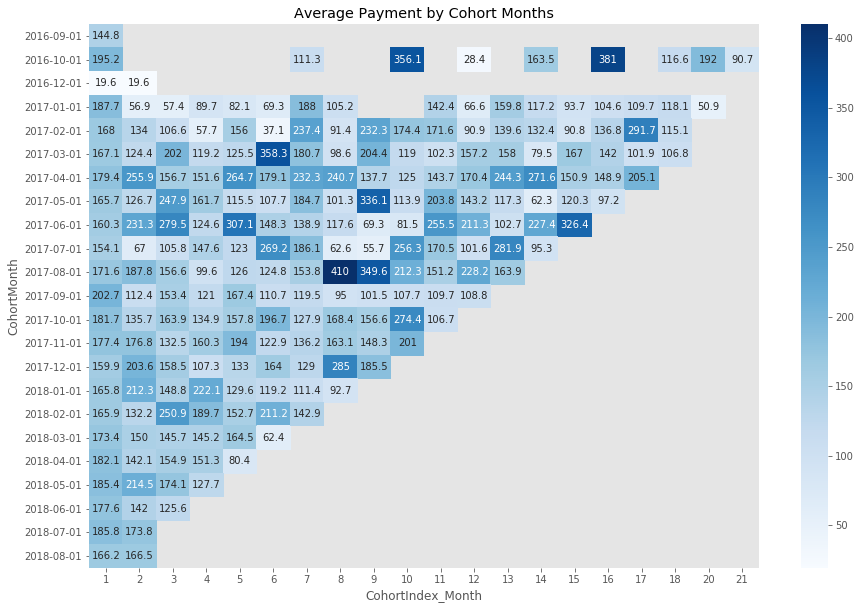

In [13]:
# --- calculate average payment ---
# Group customers based on the cohort month and index month
monthly_grouping = olist_data_clean.groupby(['CohortMonth','CohortIndex_Month'])

# Calculate the average of the unit price column
monthly_cohort_payment = monthly_grouping['payment_value'].mean()

# Reset the index of cohort_data
monthly_cohort_payment = monthly_cohort_payment.reset_index()

# Create a pivot 
monthly_average_payment = monthly_cohort_payment.pivot(index='CohortMonth', 
                                                       columns='CohortIndex_Month',
                                                       values='payment_value')

# --- visualize average payment by monthly cohorts ---
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(15, 10))

# Add a title
plt.title('Average Payment by Cohort Months')

# Create the heatmap
sns.heatmap(monthly_average_payment.round(1), annot=True, cmap='Blues', fmt='g')
plt.show()

### Results: Monthy Average Payment ###
From this cohort matrix plot, the highest average payment (202.7 Brazilian Real) made by customer in **Cohort 2017-07** (based on the first acquistion). However, the customer **Cohort 2017-08** in their 8th month (based on Cohort Index) had the highest average payment (410 Brazilian Real) within the entire customer lifecycle. 

### Cohort Analysis - Monthly Retention Rate ###
1. How many customers originally in each cohort?
2. How many of them were active in following months?

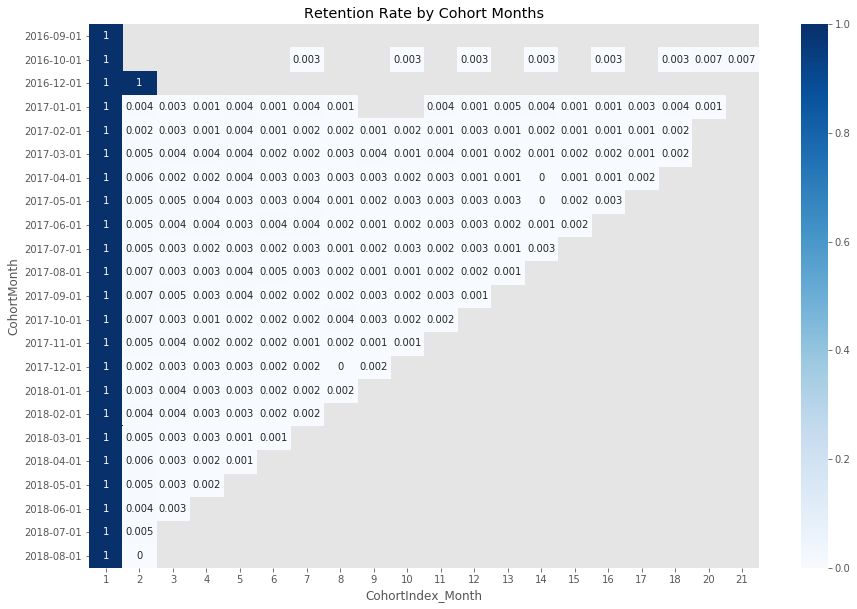

In [14]:
# --- calculate retention rate from scratch ---
# Count the number of unique values per customer_unique_id
monthly_cohort_data = monthly_grouping['customer_unique_id'].apply(pd.Series.nunique).reset_index()

# Convert the CohortMonth as object:
convert_dt_as_date_object(monthly_cohort_data, 'CohortMonth')

# Create a pivot 
monthly_cohort_counts = monthly_cohort_data.pivot(index='CohortMonth', columns='CohortIndex_Month', values='customer_unique_id')

# Extract cohort sizes from the first column of cohort_counts
monthly_cohort_sizes = monthly_cohort_counts.iloc[:,0]

# Calculate retention by dividing the counts with the cohort sizes
monthly_retention = monthly_cohort_counts.divide(monthly_cohort_sizes, axis=0)

del(monthly_cohort_data, monthly_cohort_counts, monthly_cohort_sizes)

# Calculate churn
monthly_churn = 1 - monthly_retention

# --- visualize retention rate by monthly cohorts  ---
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(15, 10))

# Add a title
plt.title('Retention Rate by Cohort Months')

# Create the heatmap
sns.heatmap(monthly_retention.round(3), annot=True, cmap='Blues', fmt='g')
plt.show()

### Results: Monthy Retention Rate ###
In general, many customer cohort groups would return in their second month (based on Cohort Index Month = 2) with the highest retention rate about **0.5-0.7%.** Also some seasonality trend was detected where retention rates were high from **July 2017 to October 2017.** 

## Part 3 - DEVELOP ##

### Customer Lifetime Value ###
CLV is a metric that estimates how much value (i.e., revenue or profit) any given customers will bring to your business over the course of total time they interact with your platform or brand. 

The goal of CLV measurements are:
* Measure customer value in revenue or profit
* Benchmark customers
* Identify maximum investment into customer acquisition

### Derivation of Retention and Churn Rates ###
Let's calculate the overall mean of retention and churn rates
* Given this is the customer's first active month, exclude the first month (i.e., CohortIndex_Month = 1) as they are constants
* Chaining: monthly mean --> overall mean rates

In [15]:
# --- 8. CLV Calculations ---
# Calculate the mean retention rate
retention_rate = monthly_retention.iloc[:,1:].mean().mean()

# Calculate the mean churn rate
churn_rate = monthly_churn.iloc[:,1:].mean().mean()

# Print rounded retention and churn rates
print('Retention rate: {:.2f}; Churn rate: {:.2f}'.format(retention_rate, churn_rate))

Retention rate: 0.01; Churn rate: 0.99


### Types of CLV Formulas ###
In general, there are three common types of CLV formulas:
* **Basic CLV** =  Monthly Revenue * Lifespan Months
* **Granular CLV** = Revenue/Purchase * Frequency/Month * Lifespan Months
* **Traditional CLV** = Monthly Revenue * (Retention Rate / Churn Rate)

**Note #1:** Each formula has its own limitations where it does not account for
* Tenure, retention and churn
* New customers and their future revenue

However, the most popular method is Traditional CLV where it accounts for customer loyalty!

**Note #2:** For simplicity, ignored the profit margin from the CLV calculations since it is not given to us.

In [16]:
###############################
# --- Calculate Basic CLV --- #
###############################
# Calculate monthly spend per customer
monthly_revenue = olist_data_clean.groupby(['customer_unique_id','PurchaseMonth'])['payment_value'].sum()

# Calculate average monthly spend
monthly_revenue = np.mean(monthly_revenue)

# Define lifespan to 21 months based on the order purchase period
lifespan_months = 21

# Calculate basic CLV
clv_basic = monthly_revenue * lifespan_months

# Print the basic CLV value: currency conversion 1 Real = 0.26 CAD
print('Average Basic CLV is {:.1f} CAD'.format(clv_basic * 0.26))

##################################
# --- Calculate Granular CLV --- #
##################################
# Calculate average revenue per invoice
revenue_per_purchase = olist_data_clean.groupby(['order_id'])['payment_value'].mean().mean()

# Calculate average number of unique orders per customer per month
frequency_per_month = olist_data_clean.groupby(['customer_unique_id','PurchaseMonth'])['order_id'].nunique().mean()

# Calculate granular CLV
clv_granular = revenue_per_purchase * frequency_per_month * lifespan_months

# Print the granular CLV value: currency conversion 1 Real = 0.26 CAD
print('Average Granular CLV is {:.1f} CAD'.format(clv_granular * 0.26))

#####################################
# --- Calculate Traditional CLV --- #
#####################################
# Calculate monthly spend per customer
monthly_revenue = olist_data_clean.groupby(['customer_unique_id','PurchaseMonth'])['payment_value'].sum().mean()

# Calculate average monthly retention rate
retention_rate = monthly_retention.iloc[:,1:].mean().mean()

# Calculate average monthly churn rate
churn_rate = 1 - retention_rate

# Calculate traditional CLV 
clv_traditional = monthly_revenue * (retention_rate / churn_rate)

# Print traditional CLV and the retention rate values: currency conversion 1 Real = 0.26 CAD
print('Average Traditional CLV is {:.1f} CAD at {:.1f} % retention_rate'.format(clv_traditional * 0.26, retention_rate*100))

Average Basic CLV is 1139.7 CAD
Average Granular CLV is 37.2 CAD
Average Traditional CLV is 0.3 CAD at 0.5 % retention_rate


### CLV Modelling ###
Inspired by the blog posts from the Retina AI, let us compare the different CLV modeling techniques.
1. Analytic Aggregate CLV
2. Analtyic Cohort CLV

Source: https://retina.ai/blog/how-to-make-customer-lifetime-value-prediction/

### Model 1: CLV by Aggregate ###
The CLV is defined as: CLV = (average spend rate)/(average churn rate). Note that averages are taken over customers and time.
Here are two major assumption for this model:
* Assumption 1: This model assumes that rate of churn and spend for all customers are constant.
* Assumption 2: Customers can churn only once and then never purchase again.

Average churn rate = (sum of inactive customers)/(customer's tenure period)

The limitations of this model come from the assumptions:
* Average spend stays constant over time
* All customers behave the same (i.e., most likely similar at some degree)

The method should treat it more as "Lifetime Total Value (LTV)" in which is the lifetime spend of customers at a population level.

In [17]:
# --- 9. CLV Model: Aggregate by Population ---
# group customers by customer's unique id
group_by_customer = olist_data_clean.groupby(
    by = olist_data_clean['customer_unique_id'],
    as_index = False)

# calculate duration bewteen first to last order purchase by customers
customers = group_by_customer['order_purchase_date'] \
    .agg({'order_purchase_date': lambda x: (x.max()-x.min())}).rename(columns={'order_purchase_date':'num_days'})

# calculate customer's tenure period in months:
customers['tenure_months'] = np.maximum(customers["num_days"] \
    .apply(lambda x: np.ceil(x.days / 30)), 1.0)

# check top 5 rows
customers.head()

# define the churning
twelve_weeks = timedelta(weeks=12)
cutoff_date = olist_data_clean['order_purchase_date'].max()

# determine whether a customer is inactive after 12 weeks
dead = group_by_customer['order_purchase_date'].max()['order_purchase_date']\
    .apply(lambda x: (cutoff_date - x) > twelve_weeks)

# calculate the customer churn ratio
churn = dead.sum() / customers['tenure_months'].sum()

# calculate net spend over customer's tenure months
spend = olist_data_clean['payment_value'].sum() / customers['tenure_months'].sum()

# calculate the overall CLV by aggregate model
clv_model_aa = spend/churn

# print the value of Aggregate CLV model: 1 Brazillian Real = 0.26 CAD
print('Aggregate CLV is {:.1f} CAD'.format(clv_model_aa * 0.26))

Aggregate CLV is 67.2 CAD


### Results: CLV by Aggregate ###
The estimated mean CLV for this model is **67.2** respectively.

### Model 2: CLV by Cohort ###
The most common way to group customers into cohorts is by start purchase date by month. The CLV is defined as: CLV = (average spend rate of cohort)/(average churn rate). 
The major assumption for this model:
* Assumption 1: Customers within same cohort behaves similarly.
* Assumption 2: For the convenience, we will choose the cohorts size of 1 and calculate average spend individually.

Average spend rate of cohort = (sum of average spend rate per cohort)/(set of customers assigned to cohort * customer's tenure period)

**Note:** CLV estimates for customers with very few purchases maybe unreliable!

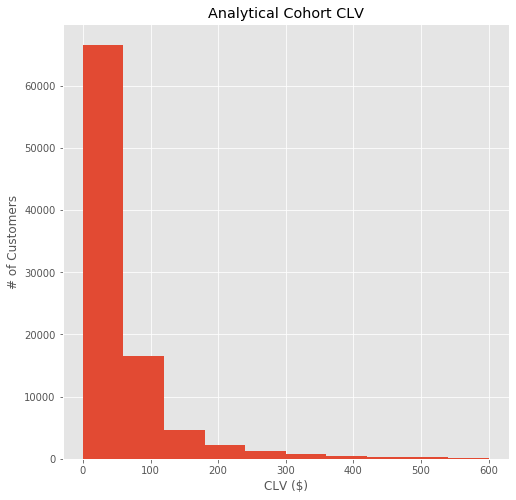

Mean CLV is 70.7 CAD, Median CLV is 37.5 CAD


In [18]:
# --- 10. CLV Model: Aggregate by Customer ---
# append the total spend by customer id
customers_ac = customers.merge(
    group_by_customer['payment_value'].sum(),
    on = 'customer_unique_id')

# calculate the CLV per customer
customers_ac['CLV'] = (customers_ac['payment_value']/customers_ac['tenure_months'])/churn

# check the top 5 rows
customers_ac.head()

# plot the histogram: Analytic CLV by Cohort
plt.figure(figsize=(8,8))
plt.hist(customers_ac['CLV']*0.26, range = (0, 600))
plt.title('Analytical Cohort CLV')
plt.xlabel('CLV ($)')
plt.ylabel('# of Customers')
plt.savefig('hist_olist_cohort_CLV_AC.png', dpi=300, bbox_inches='tight')
plt.show()

# compute mean and median CLVs by cohort
mean_clv = customers_ac['CLV'].mean()*0.26
median_clv = customers_ac['CLV'].median()*0.26

# print the mean and median of the CLV by Cohort
print('Mean CLV is {:.1f} CAD, Median CLV is {:.1f} CAD'.format(mean_clv, median_clv))

### Results: CLV by Cohort ###
The majoriy of customers fall below the CLV value of **100**. The estimated mean and median CLV using this model are **70.7** and **37.5** respectively.

## Part 4 - DEPLOY ##